# colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/github/ids

/content/drive/MyDrive/github/ids


# git

In [73]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   colab.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [70]:
!git add colab.ipynb

In [ ]:
from google.colab import userdata
print(f'''!git config --global user.email "{userdata.get('user.email')}"''')
print(f'''!git config --global user.name "{userdata.get('user.name')}"''')

In [71]:
!git commit -m "colab.ipynb"

[main 9b4f2c8] colab.ipynb
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite colab.ipynb (93%)


In [72]:
!git push

Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 1.83 KiB | 84.00 KiB/s, done.
Total 3 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/pro1710/ids.git
   810f8a4..9b4f2c8  main -> main


# code

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
%matplotlib inline

In [5]:
import importlib
import ids_common
importlib.reload(ids_common)

<module 'ids_common' from '/content/drive/MyDrive/github/ids/ids_common.py'>

In [6]:
path_to_dataset = './dataset/ML-EdgeIIoT-dataset.csv'
df = pd.read_csv(path_to_dataset, low_memory=False)

In [ ]:


to_drop_columns = ['frame.time',
                'ip.src_host',
                'ip.dst_host',
                'arp.src.proto_ipv4',
                'arp.dst.proto_ipv4',
                'http.file_data',
                'http.request.full_uri',
                'icmp.transmit_timestamp',
                'http.request.uri.query',
                'tcp.options',
                'tcp.payload',
                'tcp.srcport',
                'tcp.dstport',
                'udp.port',
                'mqtt.msg']


to_drop_1_unique = ['icmp.unused',
                    'http.tls_port',
                    'dns.qry.type',
                    'dns.retransmit_request_in',
                    'mqtt.msg_decoded_as',
                    'mbtcp.len',
                    'mbtcp.trans_id',
                    'mbtcp.unit_id',
                    'mqtt.conack.flags']


to_fix_columns = ['mqtt.topic',
                'mqtt.protoname',
                'dns.qry.name.len',
                'http.request.method',
                'http.referer',
                'http.request.version']


# to drop
# dns.qry.name.len
# dns.retransmit_request


# df.loc[(df['dns.qry.name.len'] == '0') | (df[col] == '0x00000000'), col] = '0'

#######################################

for col in to_fix_columns:
    df.loc[(df[col] == '0.0') | (df[col] == '0x00000000'), col] = '0.0'
    # encode_text_dummy(df, col)



In [8]:

def prepare_dataset_new(path_to_dataset):

    df  = pd.read_csv(path_to_dataset, low_memory=False)

    to_drop_columns = ['frame.time',
                'ip.src_host',
                'ip.dst_host',
                'arp.src.proto_ipv4',
                'arp.dst.proto_ipv4',
                'http.file_data',
                'http.request.full_uri',
                'icmp.transmit_timestamp',
                'http.request.uri.query',
                'tcp.options',
                'tcp.payload',
                'tcp.srcport',
                'tcp.dstport',
                'udp.port',
                'mqtt.msg']

    df.drop(to_drop_columns, axis=1, inplace=True)
    print(f'drop: NA: {df.isnull().sum().sum()}, DUPS: {df.duplicated().sum()}', )

    to_drop_1_unique = ['icmp.unused',
                    'http.tls_port',
                    'dns.qry.type',
                    'dns.retransmit_request_in',
                    'mqtt.msg_decoded_as',
                    'mbtcp.len',
                    'mbtcp.trans_id',
                    'mbtcp.unit_id',
                    'mqtt.conack.flags']

    df.drop(to_drop_1_unique, axis=1, inplace=True)
    print(f'drop: NA: {df.isnull().sum().sum()}, DUPS: {df.duplicated().sum()}', )

    df.dropna(axis=0, how='any', inplace=True)
    print(f'dropna: NA: {df.isnull().sum().sum()}, DUPS: {df.duplicated().sum()}', )

    to_fix_columns = ['mqtt.topic',
                    #   'mqtt.conack.flags',
                      'mqtt.protoname',
                      'dns.qry.name.len',
                      'http.request.method',
                      'http.referer',
                      'http.request.version']

    for col in to_fix_columns:
        df.loc[(df[col] == '0.0') | (df[col] == '0x00000000'), col] = '0'
        encode_text_dummy(df, col)


    df.drop_duplicates(subset=None, keep='first', inplace=True)
    print(f'drop_duplicates: NA: {df.isnull().sum().sum()}, DUPS: {df.duplicated().sum()}', )

    df['Attack_type'] = df['Attack_type'].astype('category')

    print('#'*80)
    print('TARGET: "Attack_label"')
    print(df['Attack_label'].value_counts())
    print('-'*80)
    print('TARGET: "Attack_type"')
    print(df['Attack_type'].value_counts())
    print('#'*80)

    return df

In [25]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier

SEED = random.randint(0, 42424242)
SEED = 42
print(f'SEED = {SEED}')

target_label_2_class = 'Attack_label' # 0 indicates normal and 1 indicates attacks
target_label_15_class = 'Attack_type'

def dataset_split(dataset, target):
    y = dataset[target]
    X = dataset.drop([target_label_2_class, target_label_15_class], axis=1, inplace=False)
    return train_test_split(X, y, test_size=0.3, random_state=SEED, stratify=y)

def show_cr(y_test, y_test_predict):

    cr = classification_report(y_test, y_test_predict, output_dict=True)

    paper_cols = ['Normal',
                'Back',
                'HTTP',
                'ICMP',
                'TCP',
                'UDP',
                'Fing',
                'MITM',
                'Pwd',
                'Port',
                'Rans',
                'SQL',
                'Upload',
                'Scan',
                'XSS']

    map_to_paper = {'Normal':'Normal',
                    'Back':'Backdoor',
                    'HTTP':'DDoS_HTTP',
                    'ICMP':'DDoS_ICMP',
                    'TCP':'DDoS_TCP',
                    'UDP':'DDoS_UDP',
                    'Fing':'Fingerprinting',
                    'MITM':'MITM',
                    'Pwd':'Password',
                    'Port':'Port_Scanning',
                    'Rans':'Ransomware',
                    'SQL':'SQL_injection',
                    'Upload':'Uploading',
                    'Scan':'Vulnerability_scanner',
                    'XSS':'XSS'
                    }

    header='{:^10}|'*16
    cols_pattern='{:^10}|' + '{:^10.2f}|'*15

    metrics = ['precision', 'recall', 'f1-score']

    print(header.format('Metr', *paper_cols))
    print(header.format(*['-'*10]*16))

    # print(cr)
    for m in metrics:
        vals = []
        for col in paper_cols:
            vals.append(cr[map_to_paper[col]][m])

        print(cols_pattern.format(m, *vals), f'{cr["accuracy"]:0.2f}')

    print(header.format(*['-'*10]*16))



def report(y_train, y_train_predict, y_test, y_test_predict):

    print('TRAIN:')
    print(show_cr(y_train, y_train_predict))

    print('TEST:')
    print(show_cr(y_test, y_test_predict))

def show_ds_stats(df):
    stats = []

    for col in df.columns:
        uniques = df[col].unique()
        num_uniques = len(uniques)
        stats.append((col, df[col].dtype, num_uniques))

    print(f'SHAPE: {df.shape}')

    num_rows = df.shape[0]

    for i, sts in enumerate(sorted(stats, key=lambda x: x[2])):
        c, t, u = sts
        dropped = '------------'
        if c in to_drop_columns:
            dropped = 'to_drop_columns'
            continue
        elif c in to_drop_1_unique:
            dropped = 'to_drop_1_unique'
            continue


        print(f'{i:<4}{c:<32}{str(t):<12}{u:>6} [{dropped:^24}]')

        if u < 10:
            # val_count = df[c].value_counts().sort_values()
            val_count = df.groupby('Attack_label')[c].value_counts()
            print(val_count)
        print('-'*80)

SEED = 42


# ver 0.0

drop: NA: 0, DUPS: 5604
drop: NA: 0, DUPS: 5604
dropna: NA: 0, DUPS: 5604
drop_duplicates: NA: 0, DUPS: 0
################################################################################
TARGET: "Attack_label"
1    128095
0     24101
Name: Attack_label, dtype: int64
--------------------------------------------------------------------------------
TARGET: "Attack_type"
Normal                   24101
DDoS_UDP                 14498
DDoS_ICMP                13096
DDoS_HTTP                10495
SQL_injection            10282
DDoS_TCP                 10247
Uploading                10214
Vulnerability_scanner    10062
Password                  9972
Backdoor                  9865
Ransomware                9689
XSS                       9543
Port_Scanning             8921
Fingerprinting             853
MITM                       358
Name: Attack_type, dtype: int64
################################################################################
TRAIN:
              precision    recall  f1-score  

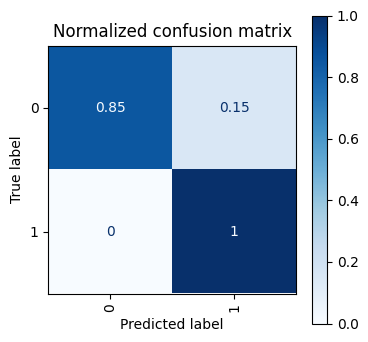

In [ ]:
df  = ids_common.prepare_dataset(path_to_dataset)

X_train, X_test, y_train, y_test = dataset_split(df, target_label_2_class)

if False:
    tree_param = {'criterion':['gini','entropy', 'log_loss'],
                'max_depth':[4,5,6,7,8,16,32,48,64,80,96,124,148]}

    dt_cls = DecisionTreeClassifier(random_state=SEED)
    grid_search = GridSearchCV(dt_cls, tree_param)

    grid_search.fit(X_train, y_train)

    print('Tuned:')
    print('Parms: ', grid_search.best_params_)
    print('Score:', grid_search.best_score_)

    dt_cls = grid_search.best_estimator_
else:
    best_params = {'criterion': 'entropy', 'max_depth': 8}
    dt_cls = DecisionTreeClassifier(**best_params, random_state=SEED)

dt_cls.fit(X_train, y_train)
y_train_predict = dt_cls.predict(X_train)
y_test_predict = dt_cls.predict(X_test)

report(y_train, y_train_predict, y_test, y_test_predict)

title='Normalized confusion matrix'

disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_test_predict,
    # display_labels=Attack_type_classes,
    cmap=plt.cm.Blues,
    normalize='true',
)
disp.ax_.set_title(title)
disp.figure_.set_size_inches(4, 4, forward=True)
plt.xticks(rotation=90)
plt.show()

drop: NA: 0, DUPS: 5604
drop: NA: 0, DUPS: 5604
dropna: NA: 0, DUPS: 5604
drop_duplicates: NA: 0, DUPS: 0
################################################################################
TARGET: "Attack_label"
1    128095
0     24101
Name: Attack_label, dtype: int64
--------------------------------------------------------------------------------
TARGET: "Attack_type"
Normal                   24101
DDoS_UDP                 14498
DDoS_ICMP                13096
DDoS_HTTP                10495
SQL_injection            10282
DDoS_TCP                 10247
Uploading                10214
Vulnerability_scanner    10062
Password                  9972
Backdoor                  9865
Ransomware                9689
XSS                       9543
Port_Scanning             8921
Fingerprinting             853
MITM                       358
Name: Attack_type, dtype: int64
################################################################################
TRAIN:
                       precision    recall  f

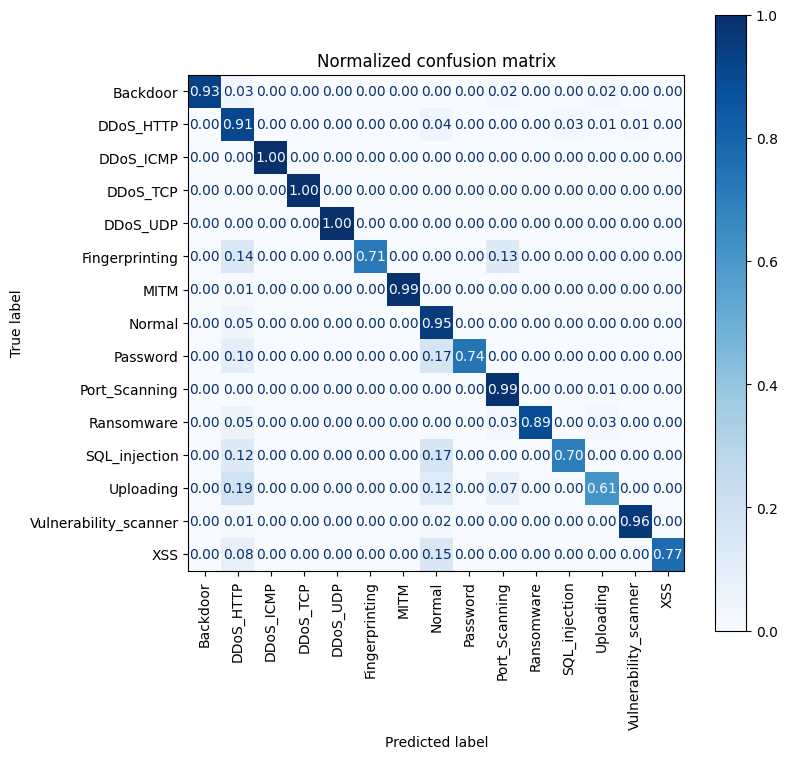

In [52]:
# 15 class

df  = ids_common.prepare_dataset(path_to_dataset)

X_train, X_test, y_train, y_test = dataset_split(df, target_label_15_class)

if False:
    tree_param = {'criterion':['gini','entropy', 'log_loss'],
                'max_depth':[4,5,6,7,8,16,32,48,64,80,96,124,148]}

    dt_cls = DecisionTreeClassifier(random_state=SEED)
    grid_search = GridSearchCV(dt_cls, tree_param, verbose=3)

    grid_search.fit(X_train, y_train)

    print('Tuned:')
    print('Parms: ', grid_search.best_params_)
    print('Score:', grid_search.best_score_)

    dt_cls = grid_search.best_estimator_
else:
    best_params = {'criterion': 'entropy', 'max_depth': 16}
    dt_cls = DecisionTreeClassifier(**best_params, random_state=SEED)

dt_cls.fit(X_train, y_train)
y_train_predict = dt_cls.predict(X_train)
y_test_predict = dt_cls.predict(X_test)

report(y_train, y_train_predict, y_test, y_test_predict)

title='Normalized confusion matrix'

disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_test_predict,
    # display_labels=Attack_type_classes,
    cmap=plt.cm.Blues,
    normalize='true',
    values_format='.2f'
)
disp.ax_.set_title(title)
disp.figure_.set_size_inches(8, 8, forward=True)

plt.xticks(rotation=90)
plt.show()

   Metr   |  Normal  |   Back   |   HTTP   |   ICMP   |   TCP    |   UDP    |   Fing   |   MITM   |   Pwd    |   Port   |   Rans   |   SQL    |  Upload  |   Scan   |   XSS    |
----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|
precision |   0.77   |   0.99   |   0.57   |   1.00   |   1.00   |   1.00   |   0.95   |   1.00   |   0.99   |   0.87   |   0.99   |   0.95   |   0.90   |   0.98   |   0.99   | 0.89
  recall  |   0.95   |   0.93   |   0.91   |   1.00   |   1.00   |   1.00   |   0.71   |   0.99   |   0.74   |   0.99   |   0.89   |   0.70   |   0.61   |   0.96   |   0.77   | 0.89
 f1-score |   0.85   |   0.96   |   0.70   |   1.00   |   1.00   |   1.00   |   0.81   |   1.00   |   0.84   |   0.93   |   0.93   |   0.81   |   0.73   |   0.97   |   0.86   | 0.89
----------|----------|----------|----------|----------|----------|----------|----------|----------|-

# ver 0.1:

In [33]:
df = ids_common.prepare_dataset(path_to_dataset)
df.drop(df[df['Attack_label'] == 0].index, inplace=True)
df.reset_index(drop=True, inplace=True)

drop: NA: 0, DUPS: 5604
drop: NA: 0, DUPS: 5604
dropna: NA: 0, DUPS: 5604
drop_duplicates: NA: 0, DUPS: 0
################################################################################
TARGET: "Attack_label"
1    128095
0     24101
Name: Attack_label, dtype: int64
--------------------------------------------------------------------------------
TARGET: "Attack_type"
Normal                   24101
DDoS_UDP                 14498
DDoS_ICMP                13096
DDoS_HTTP                10495
SQL_injection            10282
DDoS_TCP                 10247
Uploading                10214
Vulnerability_scanner    10062
Password                  9972
Backdoor                  9865
Ransomware                9689
XSS                       9543
Port_Scanning             8921
Fingerprinting             853
MITM                       358
Name: Attack_type, dtype: int64
################################################################################


In [36]:
df['Attack_type'].value_counts()

DDoS_UDP                 14498
DDoS_ICMP                13096
DDoS_HTTP                10495
SQL_injection            10282
DDoS_TCP                 10247
Uploading                10214
Vulnerability_scanner    10062
Password                  9972
Backdoor                  9865
Ransomware                9689
XSS                       9543
Port_Scanning             8921
Fingerprinting             853
MITM                       358
Normal                       0
Name: Attack_type, dtype: int64

TRAIN:
                       precision    recall  f1-score   support

             Backdoor       1.00      0.93      0.96      6906
            DDoS_HTTP       0.63      0.93      0.75      7346
            DDoS_ICMP       1.00      1.00      1.00      9167
             DDoS_TCP       1.00      1.00      1.00      7173
             DDoS_UDP       1.00      1.00      1.00     10149
       Fingerprinting       1.00      0.69      0.82       597
                 MITM       1.00      1.00      1.00       251
             Password       0.98      0.74      0.85      6980
        Port_Scanning       0.88      1.00      0.93      6245
           Ransomware       1.00      0.89      0.94      6782
        SQL_injection       0.64      0.89      0.74      7197
            Uploading       0.92      0.64      0.75      7150
Vulnerability_scanner       1.00      0.97      0.98      7043
                  XSS       0.99      0.76      0.86      6680

             accuracy                         

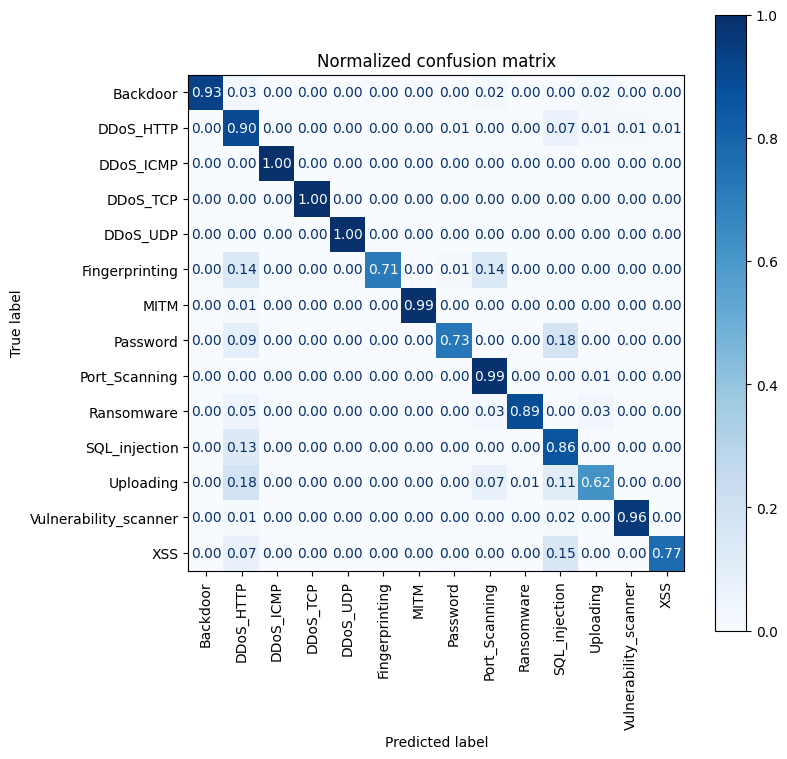

In [38]:

X_train, X_test, y_train, y_test = dataset_split(df, target_label_15_class)

if False:
    tree_param = {'criterion':['gini','entropy', 'log_loss'],
                'max_depth':[8,16,32,64,128,148]}

    dt_cls = DecisionTreeClassifier(random_state=SEED)
    grid_search = GridSearchCV(dt_cls, tree_param, verbose=3)

    grid_search.fit(X_train, y_train)

    print('Tuned:')
    print('Parms: ', grid_search.best_params_)
    print('Score:', grid_search.best_score_)

    dt_cls = grid_search.best_estimator_
else:
    best_params = {'criterion': 'entropy', 'max_depth': 16}
    dt_cls = DecisionTreeClassifier(**best_params, random_state=SEED)

dt_cls.fit(X_train, y_train)
y_train_predict = dt_cls.predict(X_train)
y_test_predict = dt_cls.predict(X_test)

report(y_train, y_train_predict, y_test, y_test_predict)

title='Normalized confusion matrix'

disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_test_predict,
    # display_labels=Attack_type_classes,
    cmap=plt.cm.Blues,
    normalize='true',
    values_format='.2f'
)
disp.ax_.set_title(title)
disp.figure_.set_size_inches(8, 8, forward=True)

plt.xticks(rotation=90)
plt.show()

In [39]:
# df  = ids_common.prepare_dataset('./dataset/DNN-EdgeIIoT-dataset.csv')



drop: NA: 0, DUPS: 309530
drop: NA: 0, DUPS: 309530
dropna: NA: 0, DUPS: 309530
drop_duplicates: NA: 0, DUPS: 0
################################################################################
TARGET: "Attack_label"
0    1363998
1     545673
Name: Attack_label, dtype: int64
--------------------------------------------------------------------------------
TARGET: "Attack_type"
Normal                   1363998
DDoS_UDP                  121567
DDoS_ICMP                  67939
SQL_injection              50826
DDoS_TCP                   50062
Vulnerability_scanner      50026
Password                   49933
DDoS_HTTP                  48544
Uploading                  36807
Backdoor                   24026
Port_Scanning              19977
XSS                        15066
Ransomware                  9689
Fingerprinting               853
MITM                         358
Name: Attack_type, dtype: int64
################################################################################


TRAIN:
                       precision    recall  f1-score   support

             Backdoor       1.00      0.93      0.97     16818
            DDoS_HTTP       0.92      0.69      0.79     33981
            DDoS_ICMP       1.00      1.00      1.00     47557
             DDoS_TCP       1.00      1.00      1.00     35044
             DDoS_UDP       1.00      1.00      1.00     85097
       Fingerprinting       0.99      0.68      0.81       597
                 MITM       1.00      1.00      1.00       251
               Normal       0.96      1.00      0.98    954798
             Password       1.00      0.73      0.85     34953
        Port_Scanning       0.85      1.00      0.92     13984
           Ransomware       1.00      0.88      0.94      6782
        SQL_injection       0.97      0.70      0.81     35578
            Uploading       0.97      0.63      0.76     25765
Vulnerability_scanner       1.00      0.96      0.98     35018
                  XSS       1.00      0.76     

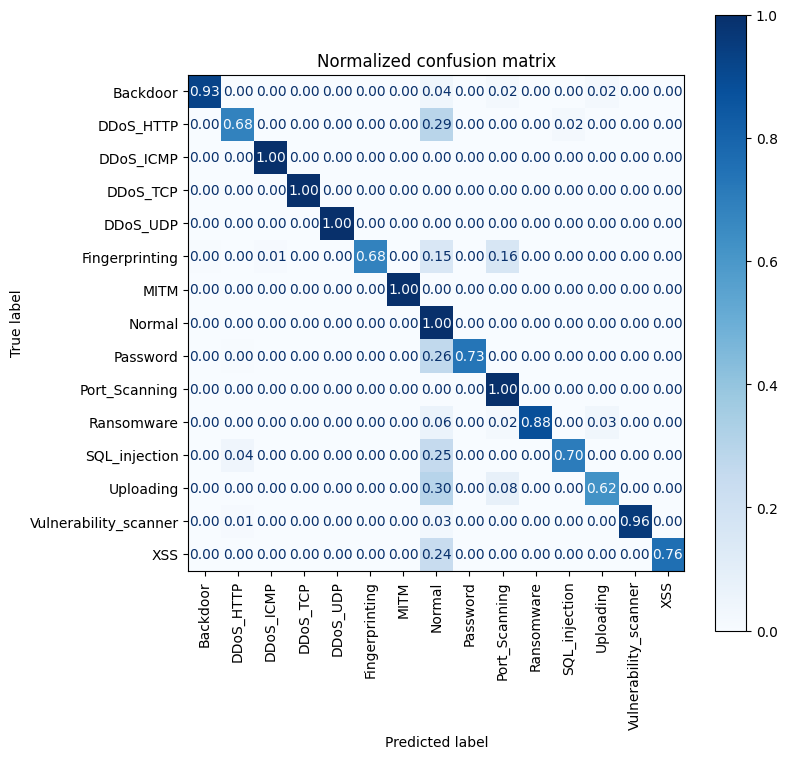

In [40]:
# X_train, X_test, y_train, y_test = dataset_split(df, target_label_15_class)

# if False:
#     tree_param = {'criterion':['gini','entropy', 'log_loss'],
#                 'max_depth':[4,5,6,7,8,16,32,48,64,80,96,124,148]}

#     dt_cls = DecisionTreeClassifier(random_state=SEED)
#     grid_search = GridSearchCV(dt_cls, tree_param, verbose=3)

#     grid_search.fit(X_train, y_train)

#     print('Tuned:')
#     print('Parms: ', grid_search.best_params_)
#     print('Score:', grid_search.best_score_)

#     dt_cls = grid_search.best_estimator_
# else:
#     best_params = {'criterion': 'entropy', 'max_depth': 16}
#     dt_cls = DecisionTreeClassifier(**best_params, random_state=SEED)

# dt_cls.fit(X_train, y_train)
# y_train_predict = dt_cls.predict(X_train)
# y_test_predict = dt_cls.predict(X_test)

# report(y_train, y_train_predict, y_test, y_test_predict)

# title='Normalized confusion matrix'

# disp = ConfusionMatrixDisplay.from_predictions(
#     y_test,
#     y_test_predict,
#     # display_labels=Attack_type_classes,
#     cmap=plt.cm.Blues,
#     normalize='true',
#     values_format='.2f'
# )
# disp.ax_.set_title(title)
# disp.figure_.set_size_inches(8, 8, forward=True)

# plt.xticks(rotation=90)
# plt.show()